# 0 – Imports/Seeds

In [ ]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
RANDOM_SEED = 77
os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# 1 – Task        
Exploring the impact of varying CNN architectures on model performance in the context of multiclass image classification.    
Implementing Early Stopping to combat overfitting: monitoring validation loss and halting training if no improvement occurs.

# 2 – The Data  

I am going to use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60,000 32x32 color images distributed across 10 different classes. *CIFAR-10* is a labeled subset of the [80 million tiny images dataset](https://groups.csail.mit.edu/vision/TinyImages/).   
The **classes** include various objects such as airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset is widely used in the field of computer vision for evaluating the performance of image classification algorithms.         

In [ ]:
# The dataset will be downloaded directly if not present in the 'root'
train = CIFAR10(root='./data', train=True, download=True, transform=None)
test = CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


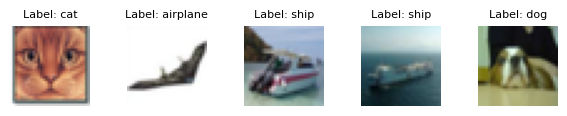

In [ ]:
num_images = 5

# Scaling factor for visibility
scale_factor = 1.2
fig, axes = plt.subplots(1, num_images, figsize=(num_images * scale_factor, scale_factor))
for i in range(num_images):
    ax = axes[i]
    random_index = random.randint(0, len(train) - 1)
    image, label = train[random_index]

    ax.imshow(image)
    ax.set_title(f"Label: {train.classes[label]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


 # 3 – IDA   
Presenting the data class distributions.   

In [ ]:
print(f"Size of training set: {len(train)} images")
print(f"Size of test set: {len(test)} images")

Size of training set: 50000 images
Size of test set: 10000 images


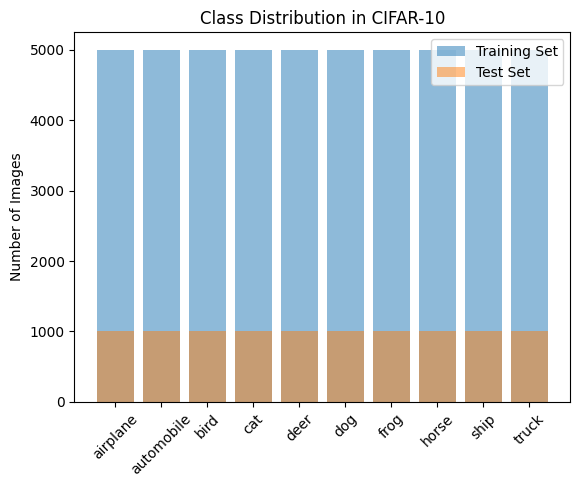

In [ ]:
# To calculate class distribution for training and test datasets
def class_distribution(dataset):
    class_counts = {label: 0 for label in dataset.classes}
    for _, label in dataset:
        class_counts[dataset.classes[label]] += 1
    return class_counts

train_class_distribution = class_distribution(train)
test_class_distribution = class_distribution(test)

plt.bar(train_class_distribution.keys(), train_class_distribution.values(), alpha=0.5, label='Training Set')
plt.bar(test_class_distribution.keys(), test_class_distribution.values(), alpha=0.5, label='Test Set')
plt.title("Class Distribution in CIFAR-10")
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.legend()
plt.show()

Each class in the test set contains exactly 1,000 images, showing an even distribution across all categories. The training set, with a total of 50,000 images, appears to have a balanced distribution as well, with 5,000 images per class.

#  4 – Preprocessing   
Converting the images into PyTorch tensors and normalizing their pixel values.


 The normalization adjusts the pixel intensities to have an average value of 0.5 and a standard deviation of 0.5, shifting the range to [-1, 1].


In [ ]:
# Transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Reloading the sets now with the transformations
trainset = CIFAR10(root='./data', train=True, transform=transform)
validset = CIFAR10(root='./data', train=True, transform=transform)
testset = CIFAR10(root='./data', train=False, transform=transform)


#  5 – Baselines    
For the sake of having some baseline, we will use a traditional Decision Tree classifier and a Dummy Classifier.

To prepare the data for these models, the images are flattened into 1D arrays, adapting them for the algorithms that are not natively suited for handling image data.

## ML algorithm (Decision Trees)

In [ ]:
# Function to convert dataset to flattened format
def flatten_dataset(dataset):
    flat_images = []
    labels = []
    for img, label in dataset:
        flat_images.append(np.array(img).flatten())
        labels.append(label)
    return np.array(flat_images), np.array(labels)

X_train, y_train = flatten_dataset(train)
X_test, y_test = flatten_dataset(test)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.2694
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.33      1000
           1       0.29      0.28      0.29      1000
           2       0.20      0.22      0.21      1000
           3       0.19      0.18      0.19      1000
           4       0.22      0.23      0.23      1000
           5       0.23      0.22      0.22      1000
           6       0.29      0.28      0.28      1000
           7       0.28      0.28      0.28      1000
           8       0.37      0.38      0.37      1000
           9       0.30      0.29      0.29      1000

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.27     10000
weighted avg       0.27      0.27      0.27     10000



## Random Guessing (Dummy)

In [ ]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=77)
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print(f"Dummy Classifier Accuracy: {accuracy_dummy}")
class_report_dummy = classification_report(y_test, y_pred_dummy)
print("Dummy Classifier Classification Report:")
print(class_report_dummy)

Dummy Classifier Accuracy: 0.1024
Dummy Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.12      0.12      1000
           1       0.11      0.11      0.11      1000
           2       0.10      0.10      0.10      1000
           3       0.10      0.10      0.10      1000
           4       0.10      0.10      0.10      1000
           5       0.09      0.09      0.09      1000
           6       0.10      0.11      0.10      1000
           7       0.09      0.09      0.09      1000
           8       0.11      0.11      0.11      1000
           9       0.10      0.10      0.10      1000

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



*Decision Tree Classifier* achieved an accuracy of 27% and overall low performance metrics as detailed in the classification report. This reflects the expected challenges faced by traditional models in handling high-dimensional image data.      
*Dummy Classifier* recorded an accuracy of ~10%, which was, of course, expected for a random classification in a scenario with 10 evenly distributed classes.

In [ ]:
# Extracting metrics from classification reports to add later to the final comparison DF
def extract_metrics_from_report(report):
    lines = report.split('\n')
    for line in lines:
        if 'weighted avg' in line:
            parts = line.split()
            precision = float(parts[-4])
            recall = float(parts[-3])
            f1_score = float(parts[-2])
            return precision, recall, f1_score

precision_dt, recall_dt, f1_dt = extract_metrics_from_report(class_report)
precision_dummy, recall_dummy, f1_dummy = extract_metrics_from_report(class_report_dummy)

 # 6 – Deep Learning Experiments    
We start with segmenting the dataset into training, validation, and test sets, followed by the implementation of an EarlyStopping mechanism. We introduce and train three CNN models, Net, Net2, and Net3. The models' training progress is reported and also visualized through loss dynamics plots, then their performance is evaluated against the test data.

Setting up **DataLoader** to iterate over the data during the training and evaluation:

In [ ]:
torch.manual_seed(RANDOM_SEED)
# The present code structure is adapted from lectures
TRAIN_SIZE = len(trainset)
VALIDATION_RATIO = 0.2
BATCH_SIZE = 256
NUM_WORKERS = 4

# Calculating the number of samples for validation
num_valid_samples = int(VALIDATION_RATIO * TRAIN_SIZE)
num_train_samples = TRAIN_SIZE - num_valid_samples

# Generating indices and creating samplers
train_indices = torch.arange(0, num_train_samples)
valid_indices = torch.arange(num_train_samples, TRAIN_SIZE)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# Creating DataLoaders
train_loader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True, sampler=train_sampler)
valid_loader = DataLoader(dataset=validset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, sampler=valid_sampler)
test_loader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

The following is my implementation of the concept of **Early Stopping** - a technique to manage overfitting.    
The *EarlyStopping class* is designed to monitor the model's performance on a validation set and halt the training process if there's no improvement in the model's loss over a certain number of epochs (defined by *patience*).    
The class saves the model at its best performance to ensure that I retain the most effective version of the model even if the training continues for additional epochs without improvement.

In [ ]:
class EarlyStopping:
    """
        Initializes the EarlyStopping.

        Args:
            patience (int): Number of epochs with no improvement after which training will be stopped.
            verbose (bool): If True, prints a message for each improvement.
            delta (float): Minimum change to qualify as an improvement.
            path (str): Path where the model is saved.
     """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.best_epoch = 0
        self.best_val_acc = None

    def __call__(self, val_loss, val_acc, epoch, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, epoch, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, epoch, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_acc, epoch, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            self.val_loss_min = val_loss
            self.best_epoch = epoch + 1
            self.best_val_acc = val_acc
            torch.save(model.state_dict(), self.path)


## Model Architectures   
Model **Net** is composed of convolutional layers for initial feature detection and pooling layers for dimensionality reduction, followed by dense layers for output classification. **Net2** modifies and extends this design by more output channels and a smaller 3x3 kernel for finer feature detection. It also incorporates dropout layers to mitigate overfitting. Lastly, we experiment by adding a third convolutional layer in the **Net3**, increasing the depth of the model, while also using batch normalization to stabilize learning.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer with 3 input channels (<--RGB images), 6 output channels, and a 5x5 kernel.
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Max pooling layer with a 2x2 window, reduces spatial dimensions by half
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer takes 6 input channels, outputs 16 channels, using a 5x5 kernel.
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected (linear) layer with 16*5*5 input features (from the previous layer) and 120 output features.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # Second fully connected layer with 120 input features and 84 output features.
        self.fc2 = nn.Linear(120, 84)

        # Final fully connected layer that outputs the 10 classes. 84 input features from the previous layer.
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Applying the first convolutional layer, then ReLU activation function, then max pooling
        # Feature map calculation: (W - F + 1) x (H - F + 1)
        # (32 - 5 + 1) x (32 - 5 + 1) = 28x28.
        # 28/2 x 28/2 = 14x14
        x = self.pool(F.relu(self.conv1(x)))

        # Applying the second convolutional layer, then ReLU, then max pooling
        # (14 - 5 + 1) x (14 - 5 + 1) = 10x10
        # 5x5
        x = self.pool(F.relu(self.conv2(x)))

        # Flattening the tensor output from the previous layer
        x = x.view(-1, 16 * 5 * 5)

        # Applying the first fully connected layer and then ReLU
        x = F.relu(self.fc1(x))

        # Applying the second fully connected layer and then ReLU
        x = F.relu(self.fc2(x))

        # Applying the final fully connected layer
        x = self.fc3(x)

        return x

torch.manual_seed(RANDOM_SEED)
net = Net()

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Enhanced convolutional layer with 32 output channels and a smaller 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Second convolutional layer takes 32 input channels (from the previous layer), outputs 64 channels, and also uses a 3x3 kernel. Padding again set to 1 to maintain dimensions.
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer randomly zeros some of the input elements with a probability of 0.25, aims to help with overfitting.
        self.dropout1 = nn.Dropout2d(0.25)

        # Fully connected (linear) layer with 64*8*8 input features (from the previous layer) and 512 output features.
        self.fc1 = nn.Linear(64 * 8 * 8, 512)

        # Another Dropout layer, this time with a probability of 0.5.
        self.dropout2 = nn.Dropout(0.5)

        # Final fully connected layer that outputs our 10 classes. 512 input features from the previous layer.
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Introduces dropout
        x = self.dropout1(x)

        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))

        # Applying the second Dropout layer
        x = self.dropout2(x)

        x = self.fc2(x)

        return x

torch.manual_seed(RANDOM_SEED)
net2 = Net2()

In [25]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Two convolutional layers (and pooling layer) from Net2
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) #  Additional third convolutional layer with 128 output channels
        self.pool = nn.MaxPool2d(2, 2)

        # Adjusted fully connected layer for the increased number of features from the extra conv layer
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

        # Batch normalization layers for the first two convolutional layers
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # Applying batch normalization
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout(x) # dropout after the second batch normalization

        # Processing through the third convolutional layer
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

torch.manual_seed(RANDOM_SEED)
net3 = Net3()

## Model Training and Loss Plots   
For model training, I am using standards: CrossEntropyLoss as the criterion for multi-class classification, and the Adam optimizer with a commonly used learning rate of 0.001.

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def train_model(model, trainloader, valid_loader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Lists to store performance metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            for val_inputs, val_labels in valid_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total_val_predictions += val_labels.size(0)
                correct_val_predictions += (val_predicted == val_labels).sum().item()

        epoch_val_loss = val_loss / len(valid_loader)
        val_losses.append(epoch_val_loss)
        epoch_val_acc = correct_val_predictions / total_val_predictions
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}')

        # Early Stopping based on validation loss
        early_stopping(epoch_val_loss, epoch_val_acc, epoch, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print('----------------------------------------------------------')
    print(f'Best Epoch: {early_stopping.best_epoch}')
    print(f'Validation Accuracy: {early_stopping.best_val_acc}')
    print(f'Validation Loss: {early_stopping.val_loss_min}')
    print('----------------------------------------------------------')

    return model, train_losses, val_losses, val_accuracies

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# --- MODEL 1: NET ---
optimizer1 = torch.optim.Adam(net.parameters(), lr=0.001)
model_1, train_losses, val_losses, accuracies = train_model(net, train_loader, valid_loader, criterion, optimizer1)

Epoch [1/25], Train Loss: 1.8596, Val Loss: 1.6751, Val Accuracy: 0.3975
Validation loss decreased (inf --> 1.675129). Saving model ...
Epoch [2/25], Train Loss: 1.5354, Val Loss: 1.4776, Val Accuracy: 0.4612
Validation loss decreased (1.675129 --> 1.477638). Saving model ...
Epoch [3/25], Train Loss: 1.4411, Val Loss: 1.4348, Val Accuracy: 0.4837
Validation loss decreased (1.477638 --> 1.434760). Saving model ...
Epoch [4/25], Train Loss: 1.3823, Val Loss: 1.4005, Val Accuracy: 0.4884
Validation loss decreased (1.434760 --> 1.400467). Saving model ...
Epoch [5/25], Train Loss: 1.3241, Val Loss: 1.3115, Val Accuracy: 0.5276
Validation loss decreased (1.400467 --> 1.311480). Saving model ...
Epoch [6/25], Train Loss: 1.2742, Val Loss: 1.2960, Val Accuracy: 0.5419
Validation loss decreased (1.311480 --> 1.296009). Saving model ...
Epoch [7/25], Train Loss: 1.2279, Val Loss: 1.2743, Val Accuracy: 0.5448
Validation loss decreased (1.296009 --> 1.274283). Saving model ...
Epoch [8/25], Trai

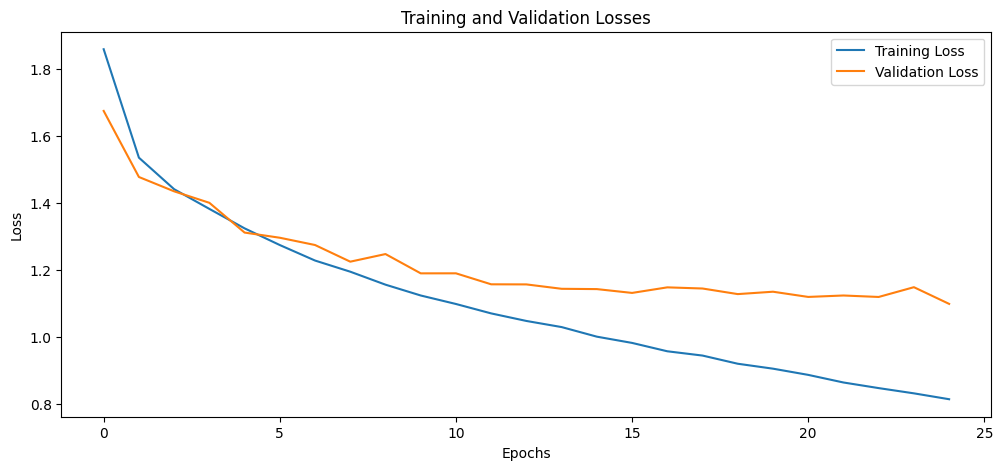

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
# --- MODEL 2: NET2 ---
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.001)
model2, train_losses2, val_losses2, accuracies2 = train_model(net2, train_loader, valid_loader, criterion, optimizer2)

Epoch [1/25], Train Loss: 1.6268, Val Loss: 1.2972, Val Accuracy: 0.5348
Validation loss decreased (inf --> 1.297174). Saving model ...
Epoch [2/25], Train Loss: 1.2816, Val Loss: 1.1350, Val Accuracy: 0.5998
Validation loss decreased (1.297174 --> 1.134971). Saving model ...
Epoch [3/25], Train Loss: 1.1319, Val Loss: 1.0119, Val Accuracy: 0.6444
Validation loss decreased (1.134971 --> 1.011918). Saving model ...
Epoch [4/25], Train Loss: 1.0265, Val Loss: 0.9627, Val Accuracy: 0.6675
Validation loss decreased (1.011918 --> 0.962710). Saving model ...
Epoch [5/25], Train Loss: 0.9538, Val Loss: 0.9044, Val Accuracy: 0.6916
Validation loss decreased (0.962710 --> 0.904446). Saving model ...
Epoch [6/25], Train Loss: 0.8918, Val Loss: 0.8632, Val Accuracy: 0.7025
Validation loss decreased (0.904446 --> 0.863224). Saving model ...
Epoch [7/25], Train Loss: 0.8396, Val Loss: 0.8352, Val Accuracy: 0.7106
Validation loss decreased (0.863224 --> 0.835195). Saving model ...
Epoch [8/25], Trai

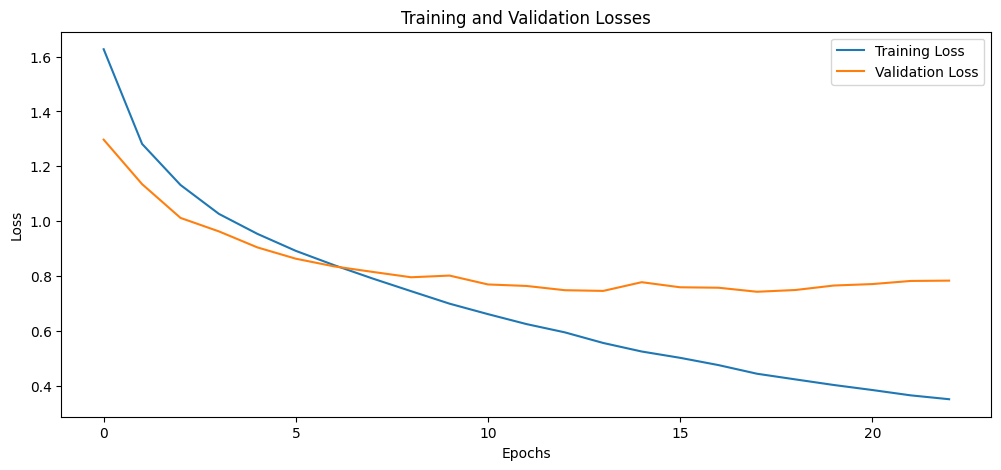

In [ ]:
plot_losses(train_losses2, val_losses2)

In [26]:
# --- NET3 ----
optimizer3 = torch.optim.Adam(net3.parameters(), lr=0.001)
model3, train_losses3, val_losses3, accuracies3 = train_model(net3, train_loader, valid_loader, criterion, optimizer3)

Epoch [1/25], Train Loss: 1.5668, Val Loss: 1.2582, Val Accuracy: 0.5490
Validation loss decreased (inf --> 1.258207). Saving model ...
Epoch [2/25], Train Loss: 1.1572, Val Loss: 1.0298, Val Accuracy: 0.6323
Validation loss decreased (1.258207 --> 1.029844). Saving model ...
Epoch [3/25], Train Loss: 0.9966, Val Loss: 0.9040, Val Accuracy: 0.6859
Validation loss decreased (1.029844 --> 0.903976). Saving model ...
Epoch [4/25], Train Loss: 0.8976, Val Loss: 0.8359, Val Accuracy: 0.7071
Validation loss decreased (0.903976 --> 0.835940). Saving model ...
Epoch [5/25], Train Loss: 0.8163, Val Loss: 0.7729, Val Accuracy: 0.7207
Validation loss decreased (0.835940 --> 0.772922). Saving model ...
Epoch [6/25], Train Loss: 0.7627, Val Loss: 0.7311, Val Accuracy: 0.7438
Validation loss decreased (0.772922 --> 0.731090). Saving model ...
Epoch [7/25], Train Loss: 0.7125, Val Loss: 0.7211, Val Accuracy: 0.7471
Validation loss decreased (0.731090 --> 0.721077). Saving model ...
Epoch [8/25], Trai

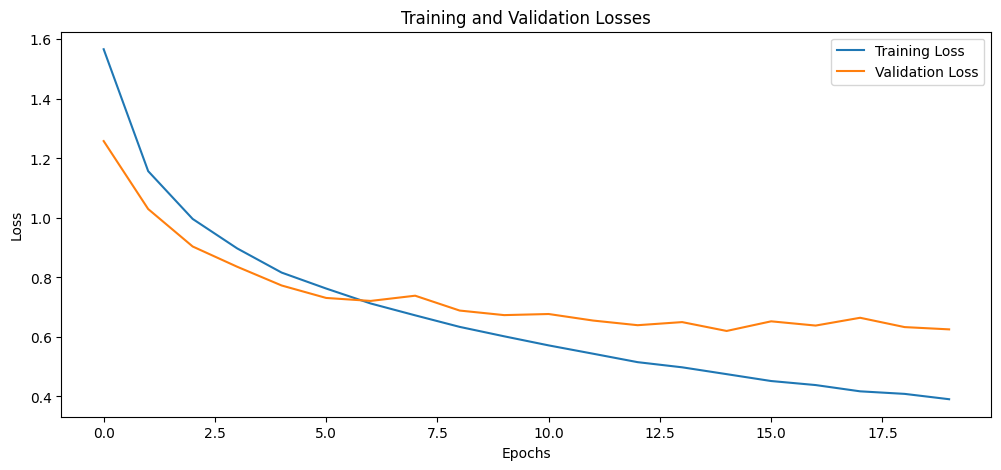

In [27]:
plot_losses(train_losses3, val_losses3)

While the training loss consistently decreases over the epochs, which we observe on both the reports and the plots, validation loss seems to plateau, justifying the employment of early stopping.

## Performance evaluation on test data

In [28]:
def evaluate_model(model, dataloader):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

In [29]:
accuracy_net, precision_net, recall_net, f1_net = evaluate_model(net, test_loader)
print("Net Performance Metrics:")
print(f"Accuracy: {accuracy_net}, Precision: {precision_net}, Recall: {recall_net}, F1: {f1_net}")


Net Performance Metrics:
Accuracy: 0.623, Precision: 0.6219436731718362, Recall: 0.623, F1: 0.6209232350760093


In [30]:
accuracy_net2, precision_net2, recall_net2, f1_net2 = evaluate_model(model2, test_loader)
print("Net2 Performance Metrics:")
print(f"Accuracy: {accuracy_net2}, Precision: {precision_net2}, Recall: {recall_net2}, F1: {f1_net2}")


Net2 Performance Metrics:
Accuracy: 0.742, Precision: 0.7432176549466323, Recall: 0.742, F1: 0.7420439212661912


In [31]:
accuracy_net3, precision_net3, recall_net3, f1_net3 = evaluate_model(model3, test_loader)
print("Net3 Performance Metrics:")
print(f"Accuracy: {accuracy_net3}, Precision: {precision_net3}, Recall: {recall_net3}, F1: {f1_net3}")

Net3 Performance Metrics:
Accuracy: 0.7917, Precision: 0.7906120706251842, Recall: 0.7917, F1: 0.7905119256676708


## Performance Comparison

In [32]:
df = pd.DataFrame({
    'Model': ['Net', 'Net2', 'Net3', 'Decision Tree', 'Dummy Classifier'],
    'Accuracy': [accuracy_net, accuracy_net2, accuracy_net3, accuracy, accuracy_dummy],
    'Precision': [precision_net, precision_net2, precision_net3, precision_dt, precision_dummy],
    'Recall': [recall_net, recall_net2, recall_net3, recall_dt, recall_dummy],
    'F1 Score': [f1_net, f1_net2, f1_net3, f1_dt, f1_dummy]
})
df

,Model,Accuracy,Precision,Recall,F1 Score
0,Net,0.6230,0.621944,0.6230,0.620923
1,Net2,0.7420,0.743218,0.7420,0.742044
2,Net3,0.7917,0.790612,0.7917,0.790512
3,Decision Tree,0.2694,0.270000,0.2700,0.270000
4,Dummy Classifier,0.1024,0.100000,0.1000,0.100000


# 7 – Conclusions

**Results Summary**:  in the course of this project, I experimented with three CNN architectures (Net, Net2, Net3) in the context of multi-class image classification, using the CIFAR-10 dataset consisting of 60,000 images across 10 classes. We observed how different layers and techniques affect performance and identified the most effective model.
The performance evaluation was based on standard metrics: accuracy, precision, recall, and F1 score. Naturally, all 3 models outperformed baselines (Decision Trees/Dummy) by a large margin, with Net3 having the best overall results with 79% accuracy.
  
**Future Directions**:    
* Exploring deeper networks or more advanced architectures could potentially yield better performance.
* Involving data augmentation techniques might help our model to generalize better
* We could surely benefit from systematic search for optimal hyperparameters (learning rate, batch size, dropout rates, etc.)